In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [3]:
data = pd.read_csv("GDP_Dataset.csv")
data.head()

,date,GDP,Per Capita,Growthannualchange
0,31/12/1960,3.749265,81.5869,NaN
1,31/12/1961,4.118648,87.5174,5.9873
2,31/12/1962,4.310164,89.4933,4.4829
3,31/12/1963,4.630827,93.8839,8.6888
4,31/12/1964,5.204956,102.9612,7.5698


In [4]:
mean_val = data[' Growthannualchange'].mean()
mean_val

5.059570967741935

In [5]:
data[' Growthannualchange'].fillna(mean_val, inplace=True)
data.head()

,date,GDP,Per Capita,Growthannualchange
0,31/12/1960,3.749265,81.5869,5.059571
1,31/12/1961,4.118648,87.5174,5.987300
2,31/12/1962,4.310164,89.4933,4.482900
3,31/12/1963,4.630827,93.8839,8.688800
4,31/12/1964,5.204956,102.9612,7.569800


In [6]:
train_dates = pd.to_datetime(data["date"])
train_dates

C:\Users\haris\AppData\Local\Temp\ipykernel_34492\4098547496.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train_dates = pd.to_datetime(data["date"])


0    1960-12-31
1    1961-12-31
2    1962-12-31
3    1963-12-31
4    1964-12-31
        ...    
58   2018-12-31
59   2019-12-31
60   2020-12-31
61   2021-12-31
62   2022-12-31
Name: date, Length: 63, dtype: datetime64[ns]

In [7]:
cols = list(data)[1:4]
cols

[' GDP', ' Per Capita', ' Growthannualchange']

In [8]:
df_for_training = data[cols].astype(float)
df_for_training.head()

,GDP,Per Capita,Growthannualchange
0,3.749265,81.5869,5.059571
1,4.118648,87.5174,5.987300
2,4.310164,89.4933,4.482900
3,4.630827,93.8839,8.688800
4,5.204956,102.9612,7.569800


<Axes: >

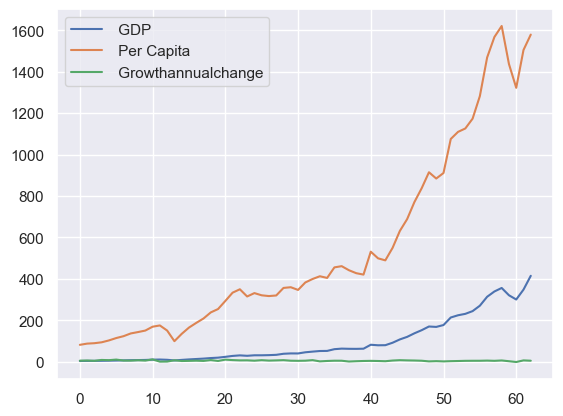

In [9]:
df_for_plot=df_for_training
df_for_plot.plot.line()

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

df_for_training_scaled

array([[-8.28023719e-01, -1.02924266e+00,  0.00000000e+00],
       [-8.24676095e-01, -1.01606977e+00,  3.88907731e-01],
       [-8.22940431e-01, -1.01168087e+00, -2.41742783e-01],
       [-8.20034336e-01, -1.00192842e+00,  1.52138737e+00],
       [-8.14831151e-01, -9.81765813e-01,  1.05229808e+00],
       [-8.08267220e-01, -9.56420008e-01,  2.24686183e+00],
       [-8.02540671e-01, -9.36521280e-01,  3.06198780e-01],
       [-7.94353362e-01, -9.06962281e-01,  1.42960738e-01],
       [-7.89119727e-01, -8.92191665e-01,  9.11194008e-01],
       [-7.83309440e-01, -8.76065889e-01,  1.87941329e-01],
       [-7.71125536e-01, -8.34804212e-01,  2.63844029e+00],
       [-7.65339990e-01, -8.21310571e-01, -1.92463728e+00],
       [-7.76676410e-01, -8.75911737e-01, -1.78001190e+00],
       [-8.04150935e-01, -9.89902778e-01,  8.40390451e-01],
       [-7.81351200e-01, -9.11639931e-01, -6.36926404e-01],
       [-7.60222168e-01, -8.44301892e-01, -3.55556672e-01],
       [-7.42663311e-01, -7.93994107e-01

In [11]:
trainx = []
trainy = []

n_futures = 1
n_past = 7

for i in range (n_past, len(df_for_training_scaled) - n_futures + 1):
    trainx.append(df_for_training_scaled [i - n_past:i, 0:df_for_training.shape[1]]) 
    trainy.append(df_for_training_scaled [i+ n_futures - 1: i + n_futures, 0])

In [76]:
trainx = np.array(trainx)
trainy = np.array(trainy)

56

In [13]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model_tune.fit(trainx, trainy, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
2/2 [==============================] - 7s 14ms/step - loss: 0.5672 - lr: 1.0000e-08
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 0.5672 - lr: 1.1220e-08
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.5672 - lr: 1.2589e-08
Epoch 4/100
2/2 [==============================] - 0s 19ms/step - loss: 0.5672 - lr: 1.4125e-08
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 0.5672 - lr: 1.5849e-08
Epoch 6/100
2/2 [==============================] - 0s 8ms/step - loss: 0.5672 - lr: 1.7783e-08
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 0.5672 - lr: 1.9953e-08
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 0.5672 - lr: 2.2387e-08
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 0.5672 - lr: 2.5119e-08
Epoch 10/100
2/2 [==============================] - 0s 19ms/step - loss: 0.5672 - lr: 2.8184e-08
Epoch 11/100
2/2 [============================

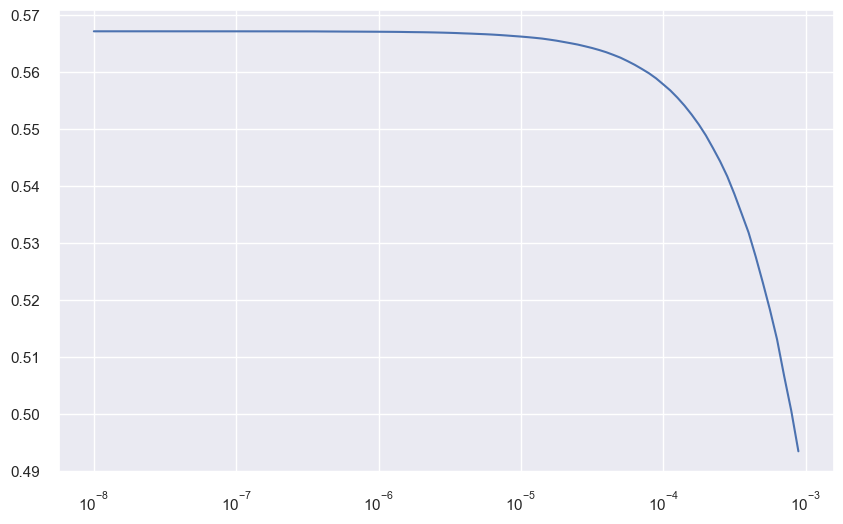

In [14]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

In [15]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
    #tf.keras.layers.Lambda(lambda x: x * 400.0)
])

learning_rate = 1e-3

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(trainx, trainy, epochs=1000, validation_split=0.1)

Epoch 1/1000
2/2 [==============================] - 4s 848ms/step - loss: 0.1971 - mae: 0.5467 - val_loss: 1.5471 - val_mae: 2.0471
Epoch 2/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.1950 - mae: 0.5447 - val_loss: 1.5435 - val_mae: 2.0435
Epoch 3/1000
2/2 [==============================] - 0s 46ms/step - loss: 0.1909 - mae: 0.5389 - val_loss: 1.5376 - val_mae: 2.0376
Epoch 4/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.1891 - mae: 0.5330 - val_loss: 1.5306 - val_mae: 2.0306
Epoch 5/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.1864 - mae: 0.5280 - val_loss: 1.5227 - val_mae: 2.0227
Epoch 6/1000
2/2 [==============================] - 0s 46ms/step - loss: 0.1818 - mae: 0.5185 - val_loss: 1.5138 - val_mae: 2.0138
Epoch 7/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.1819 - mae: 0.5150 - val_loss: 1.5031 - val_mae: 2.0031
Epoch 8/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.1750 - 

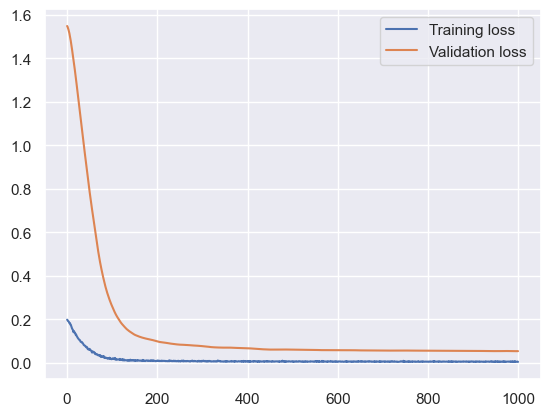

In [16]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [96]:
n_futures = 56

forecast_period_dates = pd.date_range(list(train_dates)[-1], periods= n_futures, freq= '1y').tolist()

forecast = model.predict(trainx[-n_futures:]) 

forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)

y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []

for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':data['date'][:n_futures], ' GDP':y_pred_future})

df_forecast['date']=pd.to_datetime(df_forecast['date'])

retaining_dates = df_forecast['date'][:7]

df_forecast['date'] = df_forecast['date'] + pd.DateOffset(years=7)

#df_forecast['date'] = pd.concat([retaining_dates, df_forecast['date']], axis=0, ignore_index=True)

df_forecast[' GDP'] = df_forecast[' GDP'] #+379.1759

df_forecast.head(4)

2/2 [==============================] - 0s 10ms/step


C:\Users\haris\AppData\Local\Temp\ipykernel_34492\822960222.py:18: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_forecast['date']=pd.to_datetime(df_forecast['date'])


,date,GDP
0,1967-12-31,2.857396
1,1968-12-31,1.764119
2,1969-12-31,2.971005
3,1970-12-31,0.688511


In [90]:
type(retaining_dates)

pandas.core.series.Series

In [32]:
test_forecast = model.predict(trainx)
test_forecast = test_forecast.reshape(1,-1)
test_forecast = test_forecast.flatten()
test_forecast = np.ravel(test_forecast)
test_forecast

2/2 [==============================] - 0s 8ms/step


array([-0.8361065 , -0.8460146 , -0.83507687, -0.8557626 , -0.79126513,
       -0.8184877 , -0.81466675, -0.7977945 , -0.8133636 , -0.80330116,
       -0.79450357, -0.7422427 , -0.72721976, -0.74759626, -0.6359123 ,
       -0.5814335 , -0.5421764 , -0.51032317, -0.5098602 , -0.46998912,
       -0.48816276, -0.46671516, -0.43626887, -0.43580037, -0.42767602,
       -0.41920108, -0.36134052, -0.35246706, -0.3222708 , -0.26241326,
       -0.21590228, -0.19556807, -0.17258216, -0.12385873, -0.08294229,
       -0.0382686 , -0.0047324 ,  0.07270397,  0.16418359,  0.27663463,
        0.4189232 ,  0.5500937 ,  0.6957512 ,  0.82975525,  0.96461684,
        1.1436359 ,  1.3161861 ,  1.4690052 ,  1.6086466 ,  1.74165   ,
        1.9181961 ,  2.0844796 ,  2.2134013 ,  2.2870572 ,  2.3177772 ,
        2.3945947 ], dtype=float32)

In [33]:
testvals = trainy
testvals = testvals.reshape(1,-1)
testvals = testvals.flatten()
testvals = np.ravel(testvals)
testvals

array([-0.79435336, -0.78911973, -0.78330944, -0.77112554, -0.76533999,
       -0.77667641, -0.80415094, -0.7813512 , -0.76022217, -0.74266331,
       -0.72491862, -0.70058101, -0.68357141, -0.64762798, -0.60733351,
       -0.58354047, -0.60197485, -0.57968106, -0.57974364, -0.57290897,
       -0.55974569, -0.51333339, -0.49794234, -0.49939777, -0.44851212,
       -0.41897323, -0.39246157, -0.38807966, -0.31247305, -0.28814771,
       -0.29618476, -0.29837201, -0.29128584, -0.11869578, -0.14165481,
       -0.13784318, -0.03039919,  0.11459709,  0.22602916,  0.38198799,
        0.51903183,  0.67937095,  0.6619248 ,  0.74360613,  1.07368773,
        1.1715311 ,  1.23347454,  1.35258016,  1.5899812 ,  1.98034778,
        2.21213456,  2.3655    ,  2.04632127,  1.86068144,  2.29421528,
        2.89800634])

In [34]:
print(tf.keras.metrics.mean_squared_error(testvals, test_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(testvals, test_forecast).numpy())

0.016115202
0.08457237


In [56]:
original = data[['date', ' GDP']]

original['date']=pd.to_datetime(original['date'])

C:\Users\haris\AppData\Local\Temp\ipykernel_34492\2373293057.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  original['date']=pd.to_datetime(original['date'])
C:\Users\haris\AppData\Local\Temp\ipykernel_34492\2373293057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


Text(0.5, 1.0, 'FORECASTED DATA')

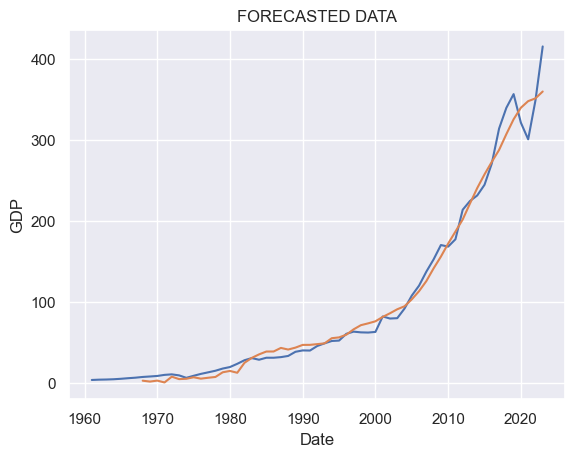

In [97]:
plt.plot(original['date'], original[' GDP'])

plt.plot(df_forecast['date'], df_forecast[' GDP'])

plt.xlabel("Date")
plt.ylabel("GDP")

plt.title("FORECASTED DATA")